In [1]:
import numpy as np
from scripts.mesh import Mesh
from scripts.topology_operations import *

In [2]:
# from functools import partial
# from multiprocessing import Pool

# pool = Pool(processes=num_test)

In [3]:
from scripts.grid import *
from scripts.segment import *

In [4]:
class SegmentReport(object):
    def __init__(self,grid_size):
        self.grid_size = grid_size
        self.num_sim = 0
        self.segments = {}
        self.segment_graph = None
    
    def __str__(self):  
        pipe_seg_ratio = self.num_pipe_segments/self.num_pipes
#         print (self.pipe_seg_report)
        return "pipes number:  %d, segment number: %d, pipe segment number %d, pipe_seg_ratio is %f" % (
            self.num_pipes, self.num_segments,self.num_pipe_segments, pipe_seg_ratio)  

    def get_segments_stats(self,trivial_pids = {}):
        self.pipe_seg_report.update_stat(trivial_pids)
        return self.pipe_seg_report.stat

In [5]:
def generate_sim_report_topo(valve_register,valid_vids,num_simulation,fail_rate):
    report = SegmentReport(grid_size)
    for i in range(num_simulation):
        valve_register.recover_valves()
        vids2fail = generate_vids2fail(valid_vids,fail_rate) 
        valves_dict = fail_valves(valve_register.vid2v,vids2fail)
        segments = simulate_segments(grid_size,valves_dict)
        report = update_segment_report(segments,report)
    return report

def generate_vids2fail(vids,fail_rate):
    num_failed_valves = int(fail_rate*len(vids))
    rand_fvids = list(np.random.choice(vids, num_failed_valves, replace=False))
    return rand_fvids


def fail_valves(valves_dict, vids2fail):
    for vid,v in valves_dict.items():
        if vid in vids2fail:
            v.fail = True
    return valves_dict       

In [6]:
# def get_trivial_pids(mesh):
#     trivial_pids = mesh.closed_pids # always closed pipes 
#     contraction_reg = mesh.contraction_reg
#     trivial_pids.update(set(contraction_reg.trivial_pids)) # always open pipes 
    
#     return trivial_pids
    
    
def get_simulation_results(reports,trivial_pids = {}):
    ave_num_segments = []
    ave_seg_pipe_size = []
    ave_max_pipe_seg = []
    for report in reports:
        stat = report.get_segments_stats(trivial_pids)
        ave_num_segments.append(stat.num_multi_pipe_seg)
        ave_seg_pipe_size.append(np.mean(stat.seg_sizes_mean))
        ave_max_pipe_seg.append(np.mean(stat.seg_sizes_max))
    return ave_num_segments,ave_seg_pipe_size,ave_max_pipe_seg

In [7]:
def get_vids2open(mesh):
    contraction_reg = mesh.contraction_reg
    vids2open = []
    for v1,v2 in contraction_reg.vpairs:
        vids2open.append(v1.vid)
        vids2open.append(v2.vid)
    return vids2open


def get_vids2close(mesh):
    vids2close = []
    for pid in mesh.closed_pids:
        v1,v2 = valve_register.pid2v[pid]
        vids2close.append(v1.vid)
        vids2close.append(v2.vid)
    return vids2close




In [8]:
def simulate_segments(grid_size,valves_dict):
    A = assemble_adjacency_mtx(grid_size,valves_dict)
    segments = find_segments(A,grid_size*grid_size)
    return segments

In [25]:
from scripts.graph import *
from scipy.sparse import lil_matrix

class SegmentSummary(object):
    def __init__(self,segments,A_diff,num_closed_pipes):
        self.segments = segments
        self.num_closed_pipes = num_closed_pipes
        self.pipe_sids = self._get_pipe_seg_ids()
        self.id2sid = self._get_id2sid()
        
        self.segment_graph = self.convert2seg_graph(A_diff)
        self.consequences = self._seg_iso_consequences()
        
    def _get_pipe_seg_ids(self):
        sids = []
        for seg in self.segments:
            if len(seg.pids):
                sids.append(seg.sid)
        return sids
    
    def _get_id2sid(self):
        id2sid ={}
        for sid, seg in enumerate(self.segments):
            for id in seg.ids:
                id2sid[id] = sid
        return id2sid
    
    def convert2seg_graph(self,A_diff):
        segment_graph = lil_matrix((len(self.segments), len(self.segments)), 
                                   dtype=np.int8)
        for i in range(A_diff.shape[0]):
            searching_sid = self.id2sid[i]
            nearby_ids = np.nonzero(A_diff[i,:])[1]
            for nearby_id in nearby_ids:
                nearby_sid = self.id2sid[nearby_id]
                segment_graph[searching_sid,nearby_sid] = 1
                
        return segment_graph
    
    def _iso_consequence(self,id):
        sid = self.id2sid[id]
        seg = self.segments[sid]
        direct_consequence = len(seg.ids)
        unintend_consequence = 0
        
        segment_graph = self.segment_graph.copy()
        segment_graph[sid,:] = 0
        segment_graph[:,sid] = 0
        
        components = bfs(segment_graph)
        for iso_component in components[1:]:
            unintend_consequence += len(iso_component)
        unintend_consequence -= (self.num_closed_pipes+1)
        unintend_consequence = max(0,unintend_consequence)
        return direct_consequence,unintend_consequence
    
    def _seg_iso_consequences(self):
        consequences = {}
        for sid in self.pipe_sids:
            direct,unintend = self._iso_consequence(sid)
            consequences[sid] = (direct,unintend)
        return consequences
        
    
    def pipe_iso_consequences(self,num_nodes,pids):
        direct_consequences = []
        unintend_consequences = []
        for pid in pids:
            id = num_nodes + pid
            sid = self.id2sid[id]
            direct,unintened = self.consequences[sid]
            direct_consequences.append(direct)
            unintend_consequences.append(unintened)
        return np.array(direct_consequences),np.array(unintend_consequences)
            
                
        
        

In [26]:
def create_null_valves_dict(valves_dict,valid_vids):
    null_dict = valves_dict.copy()
    for vid,v in null_dict.items():
        if vid in valid_vids:
            v.fail = True
    return null_dict       

def create_mtx_diff(grid_size, valves_dict,valid_vids):
    A = assemble_adjacency_mtx(grid_size,valves_dict)
    null_valves = create_null_valves_dict(valves_dict,valid_vids)
    A_null = assemble_adjacency_mtx(grid_size,null_valves)
    A_diff = A_null - A
    return A_diff
    

        
        
    
    

In [22]:
# class TestSegmentSummary(unittest.TestCase):
#     def setUp(self):
#         self.grid_size = 10
#         valves = generate_valves_grid(self.grid_size)
#         self.valve_register = ValveRegister()
#         register_valves(valves,self.valve_register)
    
#     def test_normal_condition(self):
#         fail_rate = 0.1
#         valid_vids = self.valve_register.vid2valves.keys()
#         vids2fail = generate_vids2fail(valid_vids,fail_rate) 
#         valves_dict = fail_valves(self.valve_register.vid2v,vids2fail)
#         segments = simulate_segments(grid_size,valves_dict)
        
#         mtx_diff = create_mtx_diff(self.grid_size, valves_dict)
#         seg_sum = SegmentSummary(segments,mtx_diff)
        
    

        

In [30]:
grid_size = 10
contraction_ratio = 0.
mesh = Mesh(grid_size)

nids2identify = get_nids2identify(grid_size,contraction_ratio)
identify_pairs_op =  get_identify_pairs_op(nids2identify,mesh.nid2nodes)
mesh.perform_contractions(identify_pairs_op)

mesh.degree_distribution


# mesh.reduce_degree_num(6,0)
# mesh.reduce_degree_num(5,0)
# mesh.reduce_degree_num(4,30)
# mesh.reduce_degree_num(3,80)

{0: [],
 1: [],
 2: [0, 9, 90, 99],
 3: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  10,
  19,
  20,
  29,
  30,
  39,
  40,
  49,
  50,
  59,
  60,
  69,
  70,
  79,
  80,
  89,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 4: [11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88],
 5: [],
 6: [],
 7: [],
 8: [],
 9: []}

In [31]:
valve_register = mesh.valve_register

num_nodes = grid_size*grid_size
valid_pids = mesh.valid_pids
print (len(valid_pids)/(len(mesh.bfs_edges)-len(mesh.get_open_pids())))

valid_vids = mesh.valid_vids
trivial_pids = list(mesh.get_open_pids()) +list(mesh.get_closed_pids())
print (len(valid_vids),len(valve_register.vid2v))

num_closed_pipes = len(mesh.get_closed_pids())

1.8181818181818181
360 360


In [33]:
fail_rates = np.linspace(0,0.9,10)

for fail_rate in fail_rates:
    print (f'fail rate : {fail_rate}')
    valve_register.recover_valves()
    vids2fail = generate_vids2fail(valid_vids,fail_rate) 
    valves_dict = fail_valves(valve_register.vid2v,vids2fail)
    segments = simulate_segments(grid_size,valves_dict)
    mtx_diff = create_mtx_diff(grid_size,valves_dict, valid_vids)

    seg_sum = SegmentSummary(segments,mtx_diff,num_closed_pipes)
    direct,unintend = seg_sum.pipe_iso_consequences(num_nodes,valid_pids)
    tot = direct + unintend 
    print (np.mean(direct), np.mean(unintend), np.mean(tot))

# seg_sum.segment_graph

fail rate : 0.0
1.0 0.0 1.0
fail rate : 0.1111111111111111
1.3944444444444444 0.0 1.3944444444444444
fail rate : 0.2222222222222222
2.327777777777778 0.0 2.327777777777778
fail rate : 0.3333333333333333
2.8444444444444446 0.8777777777777778 3.7222222222222223
fail rate : 0.4444444444444444
5.916666666666667 0.0 5.916666666666667
fail rate : 0.5555555555555556
20.733333333333334 0.48333333333333334 21.216666666666665
fail rate : 0.6666666666666666
33.92777777777778 16.127777777777776 50.05555555555556
fail rate : 0.7777777777777777
229.42222222222222 10.511111111111111 239.93333333333334
fail rate : 0.8888888888888888
275.0 1.0 276.0
fail rate : 1.0
280.0 0.0 280.0


1.7285714285714286 0.0 1.7285714285714286


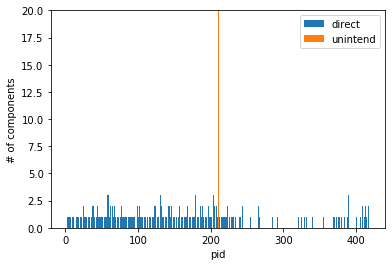

In [230]:
import matplotlib
import matplotlib.pyplot as plt


# plt.plot(fail_rates, topo_report5[2], label="dense (cr = 0.4)", linewidth=2)
plt.bar(list(valid_pids), direct, label="direct")
plt.bar(list(valid_pids), unintend, label="unintend")
# plt.bar(ids, tot[num_nodes:], label="tot")

# # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('pid')
plt.ylabel('# of components')
# # plt.xlim(left = 0, right=0.5)
plt.ylim(0,20)
plt.legend()
plt.show()

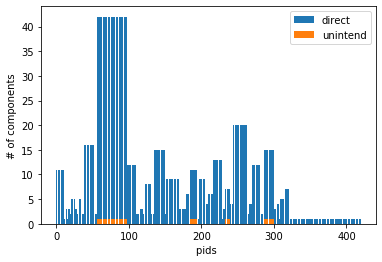

In [636]:
import matplotlib
import matplotlib.pyplot as plt

num_nodes =  grid_size*grid_size
num_pipes = len(direct)-num_nodes
ids = range(num_pipes)


# plt.plot(fail_rates, topo_report5[2], label="dense (cr = 0.4)", linewidth=2)
plt.bar(ids, direct[num_nodes:], label="direct")
plt.bar(ids, unintend[num_nodes:], label="unintend")

# # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('pids ')
plt.ylabel('# of components')
# # plt.xlim(left = 0, right=0.5)
# # plt.ylim(0,50)
plt.legend()
plt.show()

In [106]:
num_test = 15
num_simulation = 100
fail_rates = np.linspace(0, 1, num=num_test)




In [107]:
sim_report_topo = partial(generate_sim_report_topo,valve_register,valid_vids,
                          num_simulation)
reports = pool.map(sim_report_topo,fail_rates)



In [53]:
topo_report0 = get_simulation_results(reports,trivial_pids)

In [60]:
topo_report1 = get_simulation_results(reports,trivial_pids)

In [68]:
topo_report2 = get_simulation_results(reports,trivial_pids)

In [77]:
topo_report3 = get_simulation_results(reports,trivial_pids)

In [89]:
topo_report4 = get_simulation_results(reports,trivial_pids)

In [108]:
topo_report5 = get_simulation_results(reports,trivial_pids)

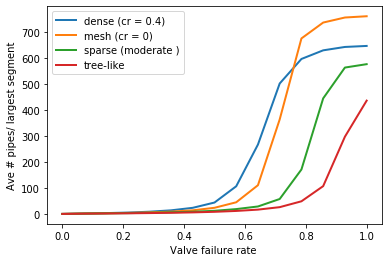

In [110]:
import matplotlib
import matplotlib.pyplot as plt

# plt.plot(fail_rates, topo_report5[2], label="dense (cr = 0.4)", linewidth=2)
plt.plot(fail_rates, topo_report0[2], label="dense (cr = 0.4)", linewidth=2)
plt.plot(fail_rates, topo_report1[2], label="mesh (cr = 0)", linewidth=2)
plt.plot(fail_rates, topo_report2[2], label="sparse (moderate )", linewidth=2)
plt.plot(fail_rates, topo_report3[2], label="tree-like", linewidth=2)
# plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/ largest segment')
# plt.xlim(left = 0, right=0.5)
# plt.ylim(0,50)
plt.legend()
plt.show()

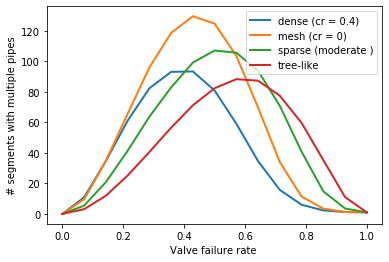

In [111]:
plt.plot(fail_rates, topo_report0[0], label="dense (cr = 0.4)", linewidth=2)
plt.plot(fail_rates, topo_report1[0], label="mesh (cr = 0)", linewidth=2)
plt.plot(fail_rates, topo_report2[0], label="sparse (moderate )", linewidth=2)
plt.plot(fail_rates, topo_report3[0], label="tree-like", linewidth=2)
# plt.plot(fail_rates, topo_report4[0], label="tree-like", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('# segments with multiple pipes')
plt.legend()
# plt.savefig('./results/num_notrivial_segs.png',dpi=300, bbox_inches='tight')

In [59]:
topo_report3

([0.0,
  1.77,
  7.04,
  14.55,
  23.11,
  32.04,
  40.2,
  47.08,
  49.89,
  48.8,
  43.43,
  33.72,
  19.23,
  6.19,
  1.0],
 [1.0,
  1.0075208990487474,
  1.0320895613170462,
  1.0727880461118073,
  1.1334847726842898,
  1.2178797023163983,
  1.3398436512514784,
  1.5188837191031306,
  1.7770845495050183,
  2.171025402453309,
  2.848497693549553,
  4.242832953723447,
  8.02486087255166,
  27.775231190378253,
  246.0],
 [1.0,
  1.95,
  2.47,
  3.18,
  4.11,
  5.14,
  6.42,
  8.33,
  11.2,
  16.56,
  25.8,
  44.83,
  93.48,
  196.03,
  246.0])